In [5]:
from keras.datasets import boston_housing

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import sys
import os

sys.path.append(os.path.abspath(".."))
import utils

In [7]:
# Načti data
(x_train_origin, y_train_origin), (x_test_origin, y_test_origin) = (
    boston_housing.load_data()
)

print(x_train_origin.shape, y_train_origin.shape)
print(x_test_origin.shape, y_test_origin.shape)
print(type(x_train_origin), type(y_train_origin))
print(type(x_test_origin), type(y_test_origin))

(404, 13) (404,)
(102, 13) (102,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


Prepare data


In [8]:
# calc mean and std
mean = x_train_origin.mean(axis=0)
std = x_train_origin.std(axis=0)

#  train data
x_train = (x_train_origin - mean) / std
y_train = y_train_origin

print(x_train.dtype)
print(y_train.dtype)

x_train = pd.DataFrame(x_train)
y_train = pd.Series(y_train)

# test data
x_test = (x_test_origin - mean) / std

x_test = pd.DataFrame(x_test)
y_test = pd.Series(y_test_origin)

float64
float64


# Train model


In [40]:
def build_model(input_dim):
    model = keras.models.Sequential(
        [
            keras.layers.Input(shape=(input_dim,)),
            keras.layers.Dense(16, activation="relu"),
            keras.layers.Dropout(0.3),
            keras.layers.Dense(4, activation="relu"),
            keras.layers.Dense(1),  # Regresní výstup
        ]
    )
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model


batch_size = 32
num_epochs = 50

## K Fold Cross Validation


processing fold # 0
- 🧠 Spouštím trénování...
✅ Fold 1 done
   📉 val_mae: 5.48 USD
   📉 val_mse: 59.47 USD
processing fold # 1
- 🧠 Spouštím trénování...
✅ Fold 2 done
   📉 val_mae: 5.03 USD
   📉 val_mse: 36.41 USD
processing fold # 2
- 🧠 Spouštím trénování...
✅ Fold 3 done
   📉 val_mae: 5.57 USD
   📉 val_mse: 67.96 USD

🎯 Final MAE scores per fold:
   Fold 1: 5.48 USD
   Fold 2: 5.03 USD
   Fold 3: 5.57 USD

🕒 Total training time: 10.44 s


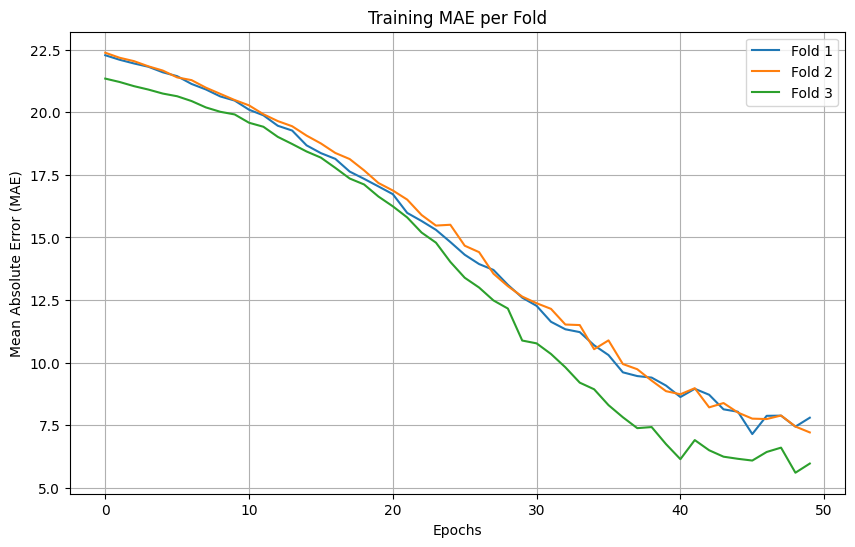

In [41]:
import keras
import time

start = time.time()

batch_size = 32
num_epochs = 50

k = 3
num_val_samples = len(x_train) // k
all_scores = []
all_histories = []
input_shape = x_train.shape[1]

for i in range(k):
    print(f"processing fold # {i}")
    val_data = x_train[i * num_val_samples : (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples : (i + 1) * num_val_samples]

    partial_train_data = pd.concat(
        [x_train[: i * num_val_samples], x_train[(i + 1) * num_val_samples :]]
    )
    partial_train_targets = pd.concat(
        [y_train[: i * num_val_samples], y_train[(i + 1) * num_val_samples :]]
    )

    model = build_model(input_shape)
    print("- 🧠 Spouštím trénování...")
    history = model.fit(
        partial_train_data,
        partial_train_targets,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_data=(val_data, val_targets),
        verbose=0,
    )

    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    print(f"✅ Fold {i + 1} done")
    print(f"   📉 val_mae: {val_mae:,.2f} USD")
    print(f"   📉 val_mse: {val_mse:,.2f} USD")

    all_scores.append(val_mae)
    all_histories.append(history)

print("\n🎯 Final MAE scores per fold:")
for i, score in enumerate(all_scores, 1):
    print(f"   Fold {i}: {score:,.2f} USD")

print(f"\n🕒 Total training time: {time.time() - start:.2f} s")

plt.figure(figsize=(10, 6))

for i, history in enumerate(all_histories):
    mae_history = history.history["mae"]
    plt.plot(mae_history, label=f"Fold {i + 1}")

plt.title("Training MAE per Fold")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend()
plt.grid(True)
plt.show()

## Train on whole datas


- 🧠 Spouštím trénování...
✅ Fold done
   📉 val_mae: 3.65 USD
   📉 val_mse: 36.36 USD

🎯 Final MAE scores per fold:
   Fold 1: 3.65 USD

🕒 Total training time: 3.47 s


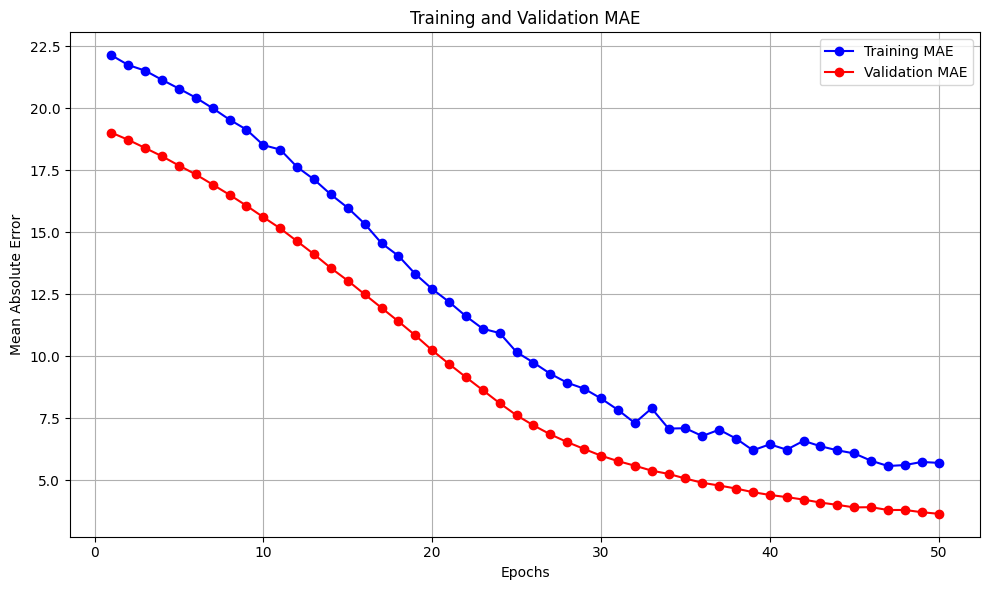

In [49]:
import keras
import time

start = time.time()

batch_size = 32
num_epochs = 50

all_scores = []
all_histories = []
input_shape = x_train.shape[1]

# Split data to train and validation
test_size = int(x_train.shape[0] / 5)

train_data = x_train[test_size:]
train_targets = y_train[test_size:]

val_data = x_train[:test_size]
val_targets = y_train[:test_size]

# random split data
# from sklearn.model_selection import train_test_split

# train_data, val_data, train_targets, val_targets = train_test_split(
#     x_train, y_train, test_size=0.2, random_state=42
# )

model = build_model(input_shape)
print("- 🧠 Spouštím trénování...")
history = model.fit(
    train_data,
    train_targets,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(val_data, val_targets),
    verbose=0,
)

val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
print(f"✅ Fold done")
print(f"   📉 val_mae: {val_mae:,.2f} USD")
print(f"   📉 val_mse: {val_mse:,.2f} USD")

all_scores.append(val_mae)
all_histories.append(history)

print("\n🎯 Final MAE scores per fold:")
for i, score in enumerate(all_scores, 1):
    print(f"   Fold {i}: {score:,.2f} USD")

print(f"\n🕒 Total training time: {time.time() - start:.2f} s")
_ = utils.plot_history(history.history, metric="mae")

## Test diffrent batch size


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

batch_sizes = [16, 64, 256]
histories = {}

for batch_size in batch_sizes:
    print(f"🔁 Train with batch size = {batch_size}")
    model = build_model(x_train.shape[1])
    history = model.fit(
        x_train,
        y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_data=(x_test, y_test),
        verbose=0,
    )
    histories[batch_size] = history

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for batch_size, history in histories.items():
    val_mae = history.history["val_mae"]
    plt.plot(val_mae, label=f"Batch {batch_size}")

plt.title("Validation MAE vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Validation MAE")
plt.legend()
plt.grid(True)
plt.show()

# test model on target data


### runn model on TEST data


5.6
50.0
23 2
min_diff = -6.79 USD | 
max_diff = 12.93 USD | 


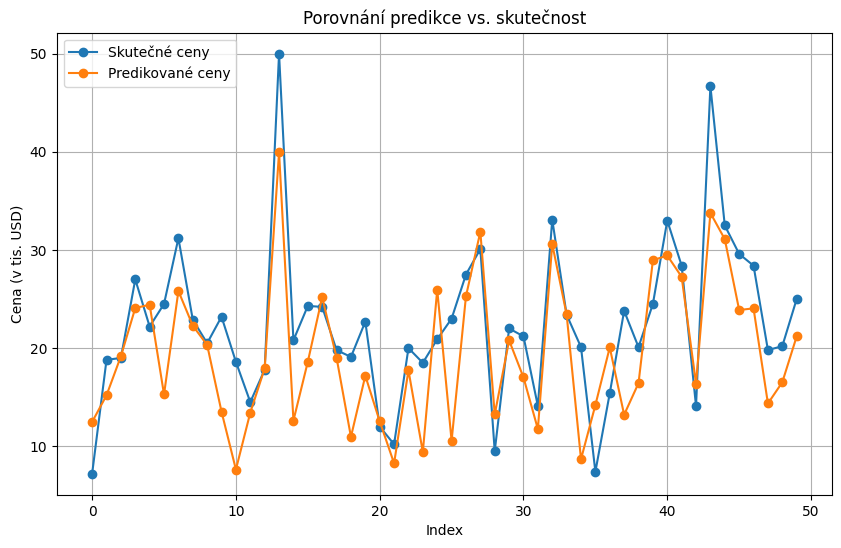

In [51]:
print(y_test_origin.min())
print(y_test_origin.max())
print(round(y_test_origin.mean()), 2)
max = 0
min = 0
count = 50
# count = x_test.shape[0]

for i in range(count):
    target = x_test.iloc[i].values.reshape(1, -1)
    predictions = model.predict(target, verbose=0)
    target_value = y_test[i]

    diff = target_value - predictions[0][0]
    pred = predictions[0][0]
    target = target_value

    if diff > max:
        max = diff
    elif diff < min:
        min = diff

    # print(
    #     f"diff = {diff:,.2f} USD | "
    #     f"prediction = {pred:,.2f} USD | "
    #     f"target = {target:,.2f} USD"
    # )

print(
    f"min_diff = {format(round(min, 2) , ',').replace(',', ' ')} USD | \n"
    f"max_diff = {format(round(max, 2), ',').replace(',', ' ')} USD | "
)

preds = [
    model.predict(x_test.iloc[i].values.reshape(1, -1), verbose=0)[0][0]
    for i in range(count)
]
trues = y_test[:count]

plt.figure(figsize=(10, 6))
plt.plot(trues.values, marker="o", label="Skutečné ceny")
plt.plot(preds, marker="o", label="Predikované ceny")
plt.title("Porovnání predikce vs. skutečnost")
plt.xlabel("Index")
plt.ylabel("Cena (v tis. USD)")
plt.legend()
plt.grid(True)
plt.show()

### run model on TRAIN data


5.0
50.0
22.395049504950492
min_diff = -5.81 USD | 
max_diff = 33.78 USD | 


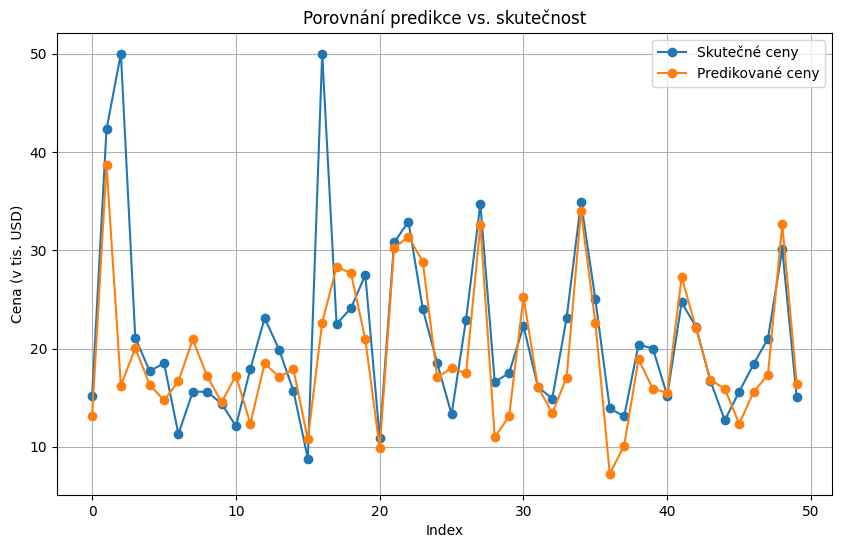

In [53]:
print(y_train_origin.min())
print(y_train_origin.max())
print(y_train_origin.mean())
max = 0
min = 0
count = x_train.shape[0]
count = 50

for i in range(count):
    target = x_train.iloc[i].values.reshape(1, -1)
    predictions = model.predict(target, verbose=0)
    target_value = y_train[i]

    diff = round(target_value - predictions[0][0], 2)
    pred = round(predictions[0][0], 2)
    target = round(target_value, 2)

    if diff > max:
        max = diff
    elif diff < min:
        min = diff

    # print(
    #     f"diff = {format(diff, ',')} USD | "
    #     f"prediction = {format(pred, ',')} USD | "
    #     f"target = {format(target, ',')} USD"
    # )
print(f"min_diff = {format(min, ',')} USD | \n" f"max_diff = {format(max, ',')} USD | ")


preds = [
    model.predict(x_train.iloc[i].values.reshape(1, -1), verbose=0)[0][0]
    for i in range(count)
]
trues = y_train[:count]

plt.figure(figsize=(10, 6))
plt.plot(trues.values, marker="o", label="Skutečné ceny")
plt.plot(preds, marker="o", label="Predikované ceny")
plt.title("Porovnání predikce vs. skutečnost")
plt.xlabel("Index")
plt.ylabel("Cena (v tis. USD)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Pokud je `trues` Pandas Series, převedeme na numpy pole
y_true = np.array(trues)
y_pred = np.array(preds)

# Vytvoříme DataFrame
df = pd.DataFrame({"y_true": y_true, "y_pred": y_pred})

# Definujeme biny (např. 15 rovnoměrných intervalů)
bins = np.linspace(df.y_true.min(), df.y_true.max(), 15)
df["bin"] = pd.cut(df["y_true"], bins)

# Agregace podle binů
grouped = (
    df.groupby("bin")
    .agg(
        true_avg=("y_true", "mean"),
        pred_avg=("y_pred", "mean"),
        pred_std=("y_pred", "std"),
    )
    .dropna()
)

# Vykreslení grafu
plt.figure(figsize=(10, 6))
plt.plot(
    grouped["true_avg"], grouped["pred_avg"], marker="o", label="Průměrná predikce"
)
plt.fill_between(
    grouped["true_avg"],
    grouped["pred_avg"] - grouped["pred_std"],
    grouped["pred_avg"] + grouped["pred_std"],
    alpha=0.3,
    label="± 1 std",
)

plt.xlabel("Skutečná hodnota (target)")
plt.ylabel("Predikovaná hodnota")
plt.title("Přesnost predikce dle cílové hodnoty")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()